In [24]:
import json
import random
import numpy as np
from pathlib import Path
from typing import Tuple, List
import math
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, LSTM, concatenate, GlobalMaxPooling2D, RepeatVector, GlobalAveragePooling2D, Dropout, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model, Sequence, to_categorical, multi_gpu_model

from livelossplot.tf_keras import PlotLossesCallback
# from tensorboardcolab import *

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

import platform
print('Python', platform.python_version())

Python 3.6.8


In [25]:
import tensorflow
tensorflow.__version__

'1.14.0'

In [26]:
COMMANDS = ['left', 'get_left_lane', 'keep_lane', 'straight', 'get_right_lane', 'right']


def command_to_onehot(command: str) -> np.array:
    """keep_lane -> [0. 0. 1. 0. 0. 0.]"""
    all_zeros = np.zeros(len(COMMANDS))
    all_zeros[COMMANDS.index(command)] = 1
    return all_zeros


def onehot_to_command(onehot: np.array):
    """[0. 0. 1. 0. 0. 0.] -> keep_lane"""
    return COMMANDS[np.argmax(onehot)]

    
def load_image(path: Path):
    height, width, channels = 224, 224, 3
    image = load_img(str(path), target_size=(height, width, channels))
    return image


def load_preprocessed_image(path: Path, preprocessor='mobilenet_v2') -> np.ndarray:
    """preprocessor: mobilenet_v2 or vgg16"""
    image = load_image(path)
    image_arr = img_to_array(image)
    
    height, width, channels = image_arr.shape
    image_reshaped = image_arr.reshape(height, width, channels)
    
    if preprocessor == 'mobilenet_v2':
        image_preprocessed = mobilenet_v2.preprocess_input(image_reshaped)
    else:
        image_preprocessed = vgg16.preprocess_input(image_reshaped)
    return image_preprocessed


def load_json(path: Path) -> Tuple[np.ndarray, str]:
    with path.open() as f:
        data = json.load(f)
    return data
    

def get_spline(data: dict) -> np.array:
    """Spline is reshaped from (7,2) -> (14, 1).
    1D np.array (first 7 distance values, then 7 angle values)
    """
    waypoints = data['spline']
#     relative_distance = lambda waypoint: waypoint[0]
#     relative_angle = lambda waypoint: waypoint[1]
    
    normalized_dist = lambda dist: (dist - STATS['min_dist']) / (STATS['max_dist'] - STATS['min_dist'])
    normalized_angle = lambda angle: (angle - STATS['min_angle']) / (STATS['max_angle'] - STATS['min_angle'])
    
    distances = [normalized_dist(dist) for dist, _ in waypoints]
    angles = [normalized_angle(angle) for _, angle in waypoints]
    
    return np.array(distances + angles)

def get_command_input(data: dict):
    return command_to_onehot(data['command'])


# def (path: Path) -> Tuple[np.ndarray, str]:
#     steering_angle = data.get('angle')
#     is_intersection = data.get('intersection_ahead')
#     return , command_onehot, steering_angle, is_intersection

#------------------------------------------------------------------------
# Visualization
def rel_point(point, angle, length):
    '''
    point - Tuple (x, y)
    angle - Angle (OY perspective, not OX!)
    length - Length of the line you want to plot.
    '''
    # unpack the first point
    x, y = point

    # find the end point
    endx = length * math.sin(math.radians(angle)) + x
    endy = length * math.cos(math.radians(angle)) + y
    return endx, endy
  
def plottable_spline(spline: np.array, shift_by: Tuple[float, float] = (200, 112), scale: float = 5) -> Tuple[np.array, np.array]:
    """Transform 1D array into points that can be easily visualized with plt.plot(xs, ys)."""
    vertical_shift, horizontal_shift = shift_by
    
    xs, ys = [], []
    last_point = (0, 0)
    
    distances_arr = true_dist(spline[:7])
    angles_arr = true_angle(spline[7:14])
    
    for rel_distance, rel_angle in zip(distances_arr, angles_arr):
        x, y = rel_point(last_point, rel_angle, rel_distance)
        xs.append(x)
        ys.append(y)
        last_point = (x, y)
  
    xs = np.array(xs)
    ys = np.array(ys)
    
    xs = xs * scale + horizontal_shift
    ys = vertical_shift - ys * scale
    return xs, ys

In [27]:
TRAIN_DATASET_DIRS = [
    Path('/home/bwroblew/Datasets/waypoint_predition_combined/train_dataset1+2'),
    Path('/home/bwroblew/Datasets/waypoint_predition_combined/train_dataset3')
]
TEST_DATASET_DIRS = [
    Path('/home/bwroblew/Datasets/waypoint_predition_combined/test_dataset1')
]

In [28]:
def paths(dirs, pattern):
    together = []
    for directory in dirs:
        together += list(directory.glob(pattern))
    return together

img_train = paths(TRAIN_DATASET_DIRS, '*.png')
json_train = paths(TRAIN_DATASET_DIRS, '*.json')
assert len(img_train) == len(json_train)
print(f'{len(img_train)} images found in {TRAIN_DATASET_DIRS}')

img_test = paths(TEST_DATASET_DIRS, '*.png')
json_test = paths(TEST_DATASET_DIRS, '*.json')
assert len(img_test) == len(json_test)
print(f'{len(img_test)} images found in {TEST_DATASET_DIRS}')


print(f'{len(img_train) / (len(img_train)+len(img_test)) * 100}% is training data')

262300 images found in [PosixPath('/home/bwroblew/Datasets/waypoint_predition_combined/train_dataset1+2'), PosixPath('/home/bwroblew/Datasets/waypoint_predition_combined/train_dataset3')]
25100 images found in [PosixPath('/home/bwroblew/Datasets/waypoint_predition_combined/test_dataset1')]
91.26652748782185% is training data


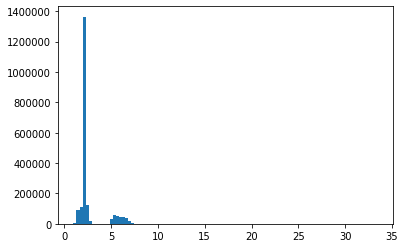

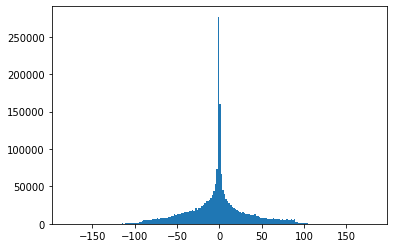

OSZUSTWO NORMALIZACJI
{
    "mean_dist": 2.6073172034833823,
    "mean_angle": -2.6909803991981107,
    "min_dist": 0.9710260388775942,
    "min_angle": -100,
    "max_dist": 10,
    "max_angle": 100
}


In [29]:
def calculate_spline_stats(json_paths):
    all_distances = []
    all_angles = []
    for idx, json_path in enumerate(json_paths):
        data = load_json(json_path)
        
        waypoints = data['spline']
        distances = [dist for dist, _ in waypoints]
        angles = [angle for _, angle in waypoints]
        
        all_distances += distances
        all_angles += angles
        
        
        
        # print(f'{idx}/{len(json_paths)}')
    assert len(all_distances) == len(all_angles)
    plt.hist(all_distances, bins=100)
    plt.show()
    plt.hist(all_angles, bins=200)
    plt.show()
    return dict(
        mean_dist = sum(all_distances) / len(all_distances),
        mean_angle = sum(all_angles) / len(all_angles),

        min_dist = min(all_distances),
        min_angle = min(all_angles),

        max_dist = max(all_distances),
        max_angle = max(all_angles),
    )

STATS = calculate_spline_stats(json_train + json_test)


print('OSZUSTWO NORMALIZACJI')
STATS['min_angle'] = -100
STATS['max_angle'] = 100
STATS['max_dist'] = 10
print(json.dumps(STATS, indent=4))

In [30]:
def true_dist(normalized_distances: np.array):
    denominator = STATS['max_dist'] - STATS['min_dist']
    return STATS['min_dist'] + (normalized_distances * denominator)

def true_angle(normalized_angles: np.array):
    denominator = STATS['max_angle'] - STATS['min_angle']
    return STATS['min_angle'] + (normalized_angles * denominator)

test data


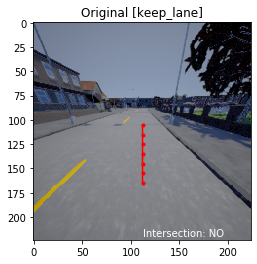

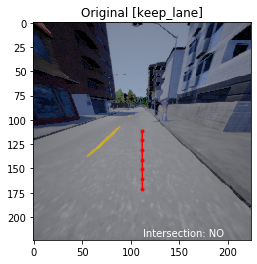

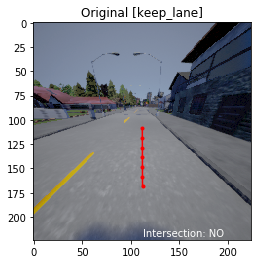

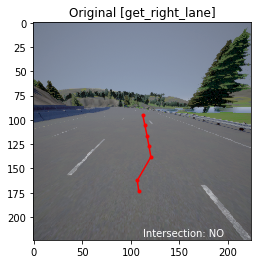

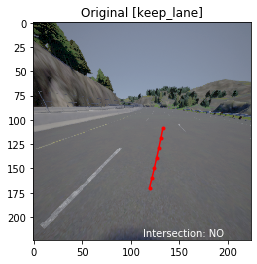

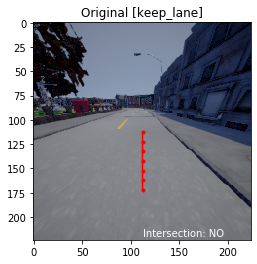

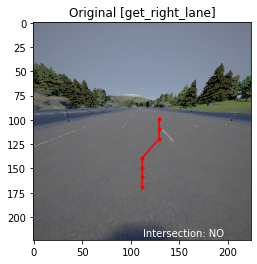

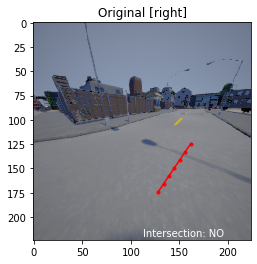

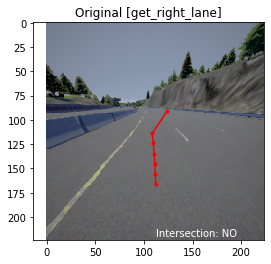

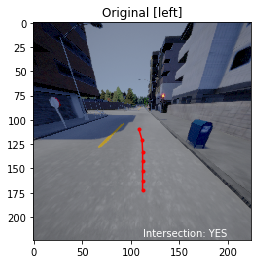

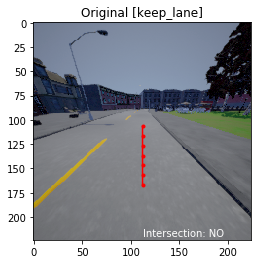

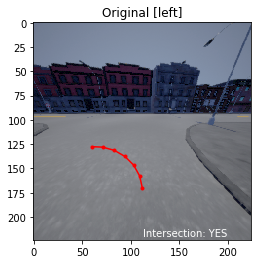

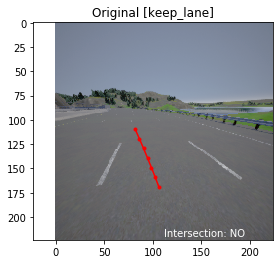

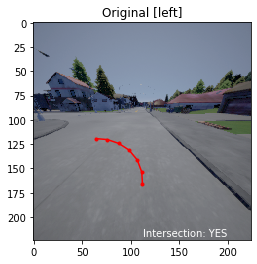

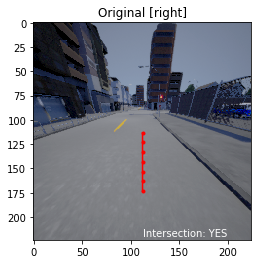

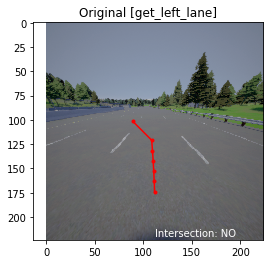

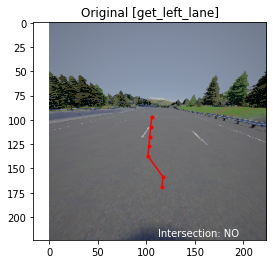

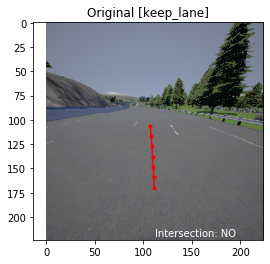

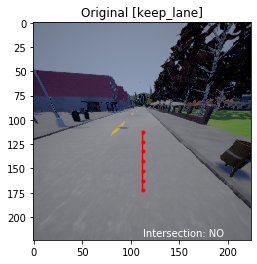

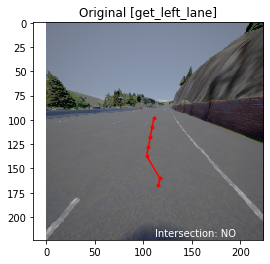

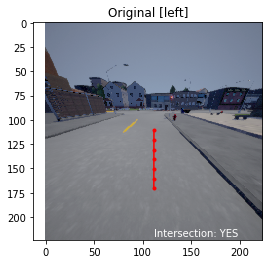

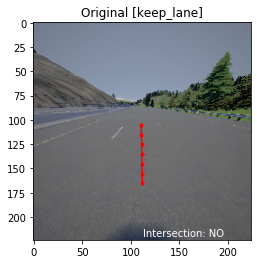

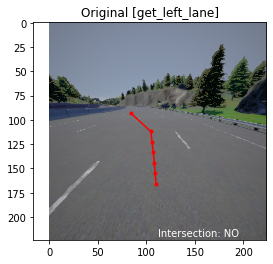

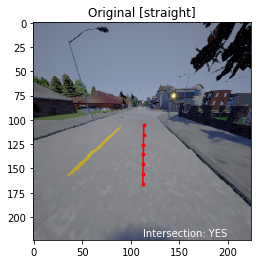

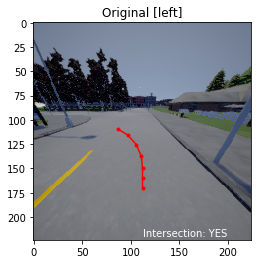

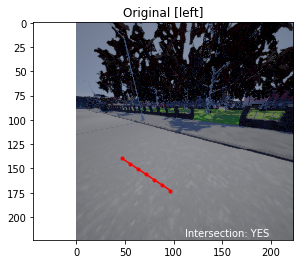

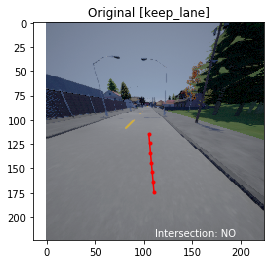

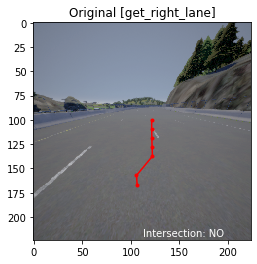

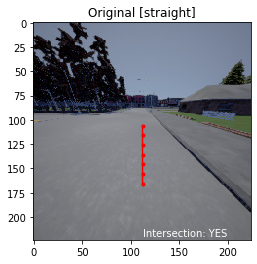

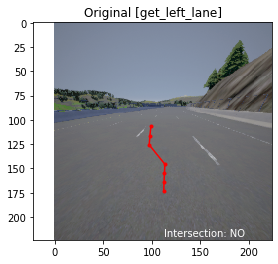

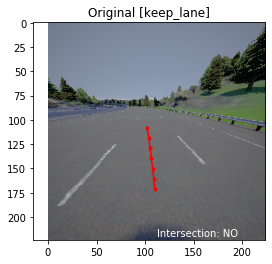

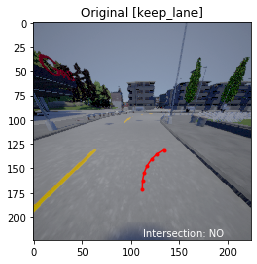

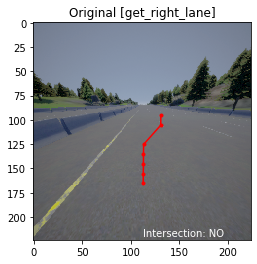

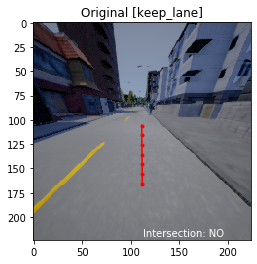

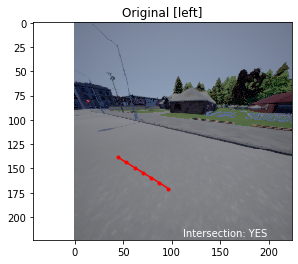

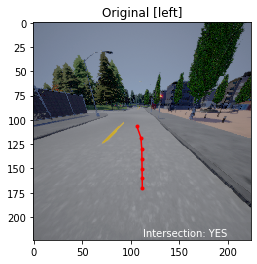

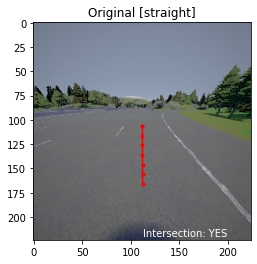

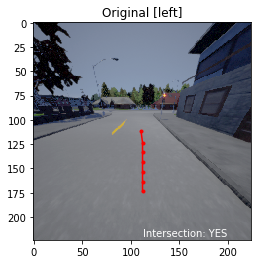

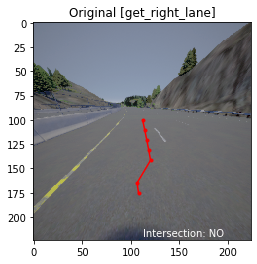

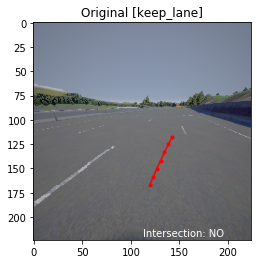

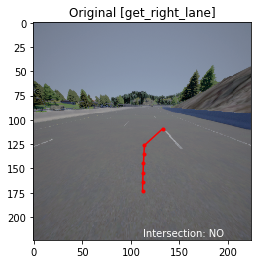

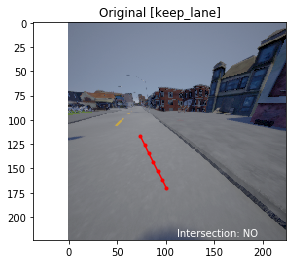

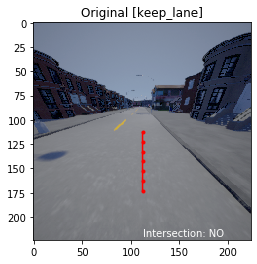

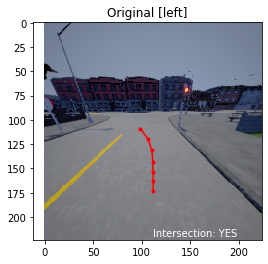

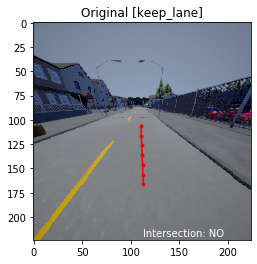

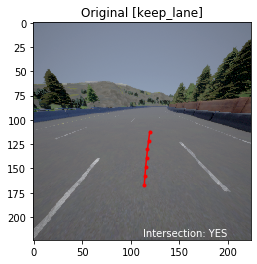

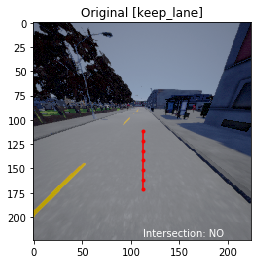

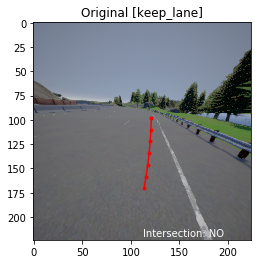

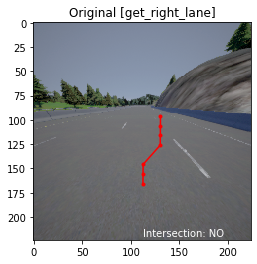

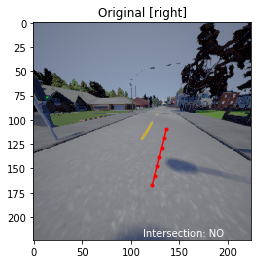

In [31]:
# Fetch all images and json files in sequence
def visualize_dataset_sample(img_path: Path, predicted_spline=None, last_row_only: bool=False):
    json_path = img_path.parent / f'{img_path.stem}.json'

    # Load original image (without preprocessing)
    original_image = load_image(img_path)

    # Load spline and command
    data = load_json(json_path)
    flatten_spline = get_spline(data)
    command = data.get('command')
    steering_angle = data.get('angle')
    intersection_ahead = data.get('intersection_ahead')
    

    # Display image with command
    plt.title(f'Original [{command}]')
    plt.imshow(original_image)

    # Overlay with spline
    xs, ys = plottable_spline(flatten_spline)
    plt.plot(xs, ys, '.-r')
    
    if predicted_spline is not None:
        xs, ys = plottable_spline(predicted_spline)
        plt.plot(xs, ys, '.-b')
    
    # Overlay is intersection
    plt.text(224/2, 220, "Intersection: YES" if intersection_ahead else "Intersection: NO", color='w')
    
    # Overlay with steering angle
    plt.barh(200, steering_angle*100)

#     if predicted_spline is not None:
#         last_frame_ax = axes[-1]
#         xs, ys = plottable_spline(predicted_spline)
#         last_frame_ax.plot(xs, ys, '.-b')
    plt.show()
    
#     save_dir = '/content/gdrive/My Drive/plots/'
#     Path(save_dir).mkdir(exist_ok=True, parents=True)
#     plot_path = f'{save_dir}/}.png'
#     plt.savefig(plot_path)
    

print('test data')
start_idx = random.randint(0, len(img_test))
sample_img_paths = img_test[start_idx:start_idx+50]
for path in sample_img_paths:
    visualize_dataset_sample(path, predicted_spline=None, last_row_only=True)

In [32]:
# # Train data
# sequences_dir = [path for path in Path(train_dataset_dir).iterdir() if path.is_dir()]
# seq_dir = random.choice(sequences_dir)
# visualize_sequence(gt_dir=seq_dir, predicted_spline=None, last_row_only=True)
def examples_per_command(path: Path):
    count = {'left': 0, 'get_left_lane': 0, 'keep_lane': 0, 'straight': 0, 'get_right_lane': 0, 'right': 0}
    json_paths = list(path.glob('*.json'))

    for json_path in json_paths:
        with json_path.open() as f:
            data = json.load(f)
            count[data['command']] += 1

    return count

In [33]:


# train_balance = examples_per_command(TRAIN_DATASET_DIR)
# test_balance = examples_per_command(TEST_DATASET_DIR)

# print('Train examples: ', json.dumps(train_balance, indent=2))
# print('Test examples: ', json.dumps(test_balance, indent=2))

In [46]:
def visualize_batch(batch):
    """Visualizes first sample in batch"""
    show_last = 10
    
    fig, axes = plt.subplots(2, 5, figsize=(45, 20), sharex='all', sharey='all')
    fig.tight_layout()
    axes = axes.ravel()
    
    X, Y = batch
    imgs = X[0] # Shape: (bs, 224, 224, 3)
    cmds = X[1] # Shape: (bs, 6)
    splines = Y # Shape: (bs, 14)  
#     print(imgs.shape)
#     print(cmds.shape)
#     print(splines.shape)
    
    for idx_in_batch in range(show_last):
        ax = axes[idx_in_batch]
        # Load preprocessed image
        preprocessed_image = imgs[idx_in_batch]
        
        # Load spline and command
        command = onehot_to_command(cmds[idx_in_batch])
        
        # Display image with command
        ax.title.set_text(f'Original [{idx_in_batch}][{command}]')
        # Line below solves this warning: https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa
        preprocessed_image = (preprocessed_image * 100).astype(np.uint8)
        ax.imshow(preprocessed_image)
        
        # Overlay with spline
        xs, ys = plottable_spline(splines[idx_in_batch])
        ax.plot(xs, ys, '.-w')
    plt.show()

class ImageDatasetGenerator(Sequence):

    def __init__(self, dataset_dirs: List[Path], batch_size: int):
        """Load paths"""
        self.batch_size = batch_size
        self.img_paths = []
        for dataset_dir in dataset_dirs:
            self.img_paths += [Path(img) for img in dataset_dir.glob('**/*.png')]
        
    def __len__(self):
        """Returns number of batches"""
        return len(self.img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        """Prepares and returns shuffled mini-batches"""
        batch_range = range(idx * self.batch_size, (idx + 1) * self.batch_size)  
        batch_of_imgs = []
        batch_of_commands = []
        batch_of_splines = []
        for img_id in batch_range:
            img_path = self.img_paths[img_id]
            json_path = img_path.parent / f'{img_path.stem}.json'
            data = load_json(json_path)
            
            # X1 => Image
            batch_of_imgs.append(load_preprocessed_image(img_path))

            # X2 => Command
            command_one_hot = get_command_input(data)
            batch_of_commands.append(command_one_hot)

            # Y => Expected sequence of splines
            spline = get_spline(data)
            batch_of_splines.append(spline)

        # Prepare randomized indexes for shuffling mini-batches
        indices = np.arange(self.batch_size)
        np.random.shuffle(indices)

        # Convert to numpy array and shuffle each batch in the same way
        batch_of_imgs = np.array(batch_of_imgs)[indices]
        batch_of_commands = np.array(batch_of_commands)[indices]
        batch_of_splines = np.array(batch_of_splines)[indices]

        # Shape: [(bs, seq_len, 224, 224, 3), (bs, seq_len, cmd_onehot_len)], (bs, seq_len, 14)
        return [batch_of_imgs, batch_of_commands], batch_of_splines

bs = 32 
print('Calculated with bs =', 32)

ds = ImageDatasetGenerator(TRAIN_DATASET_DIRS, batch_size=bs)
print('Train batches:', len(ds))

ds = ImageDatasetGenerator(TEST_DATASET_DIRS, batch_size=bs)
print('Test batches:', len(ds))

Calculated with bs = 32
Train batches: 8196
Test batches: 784


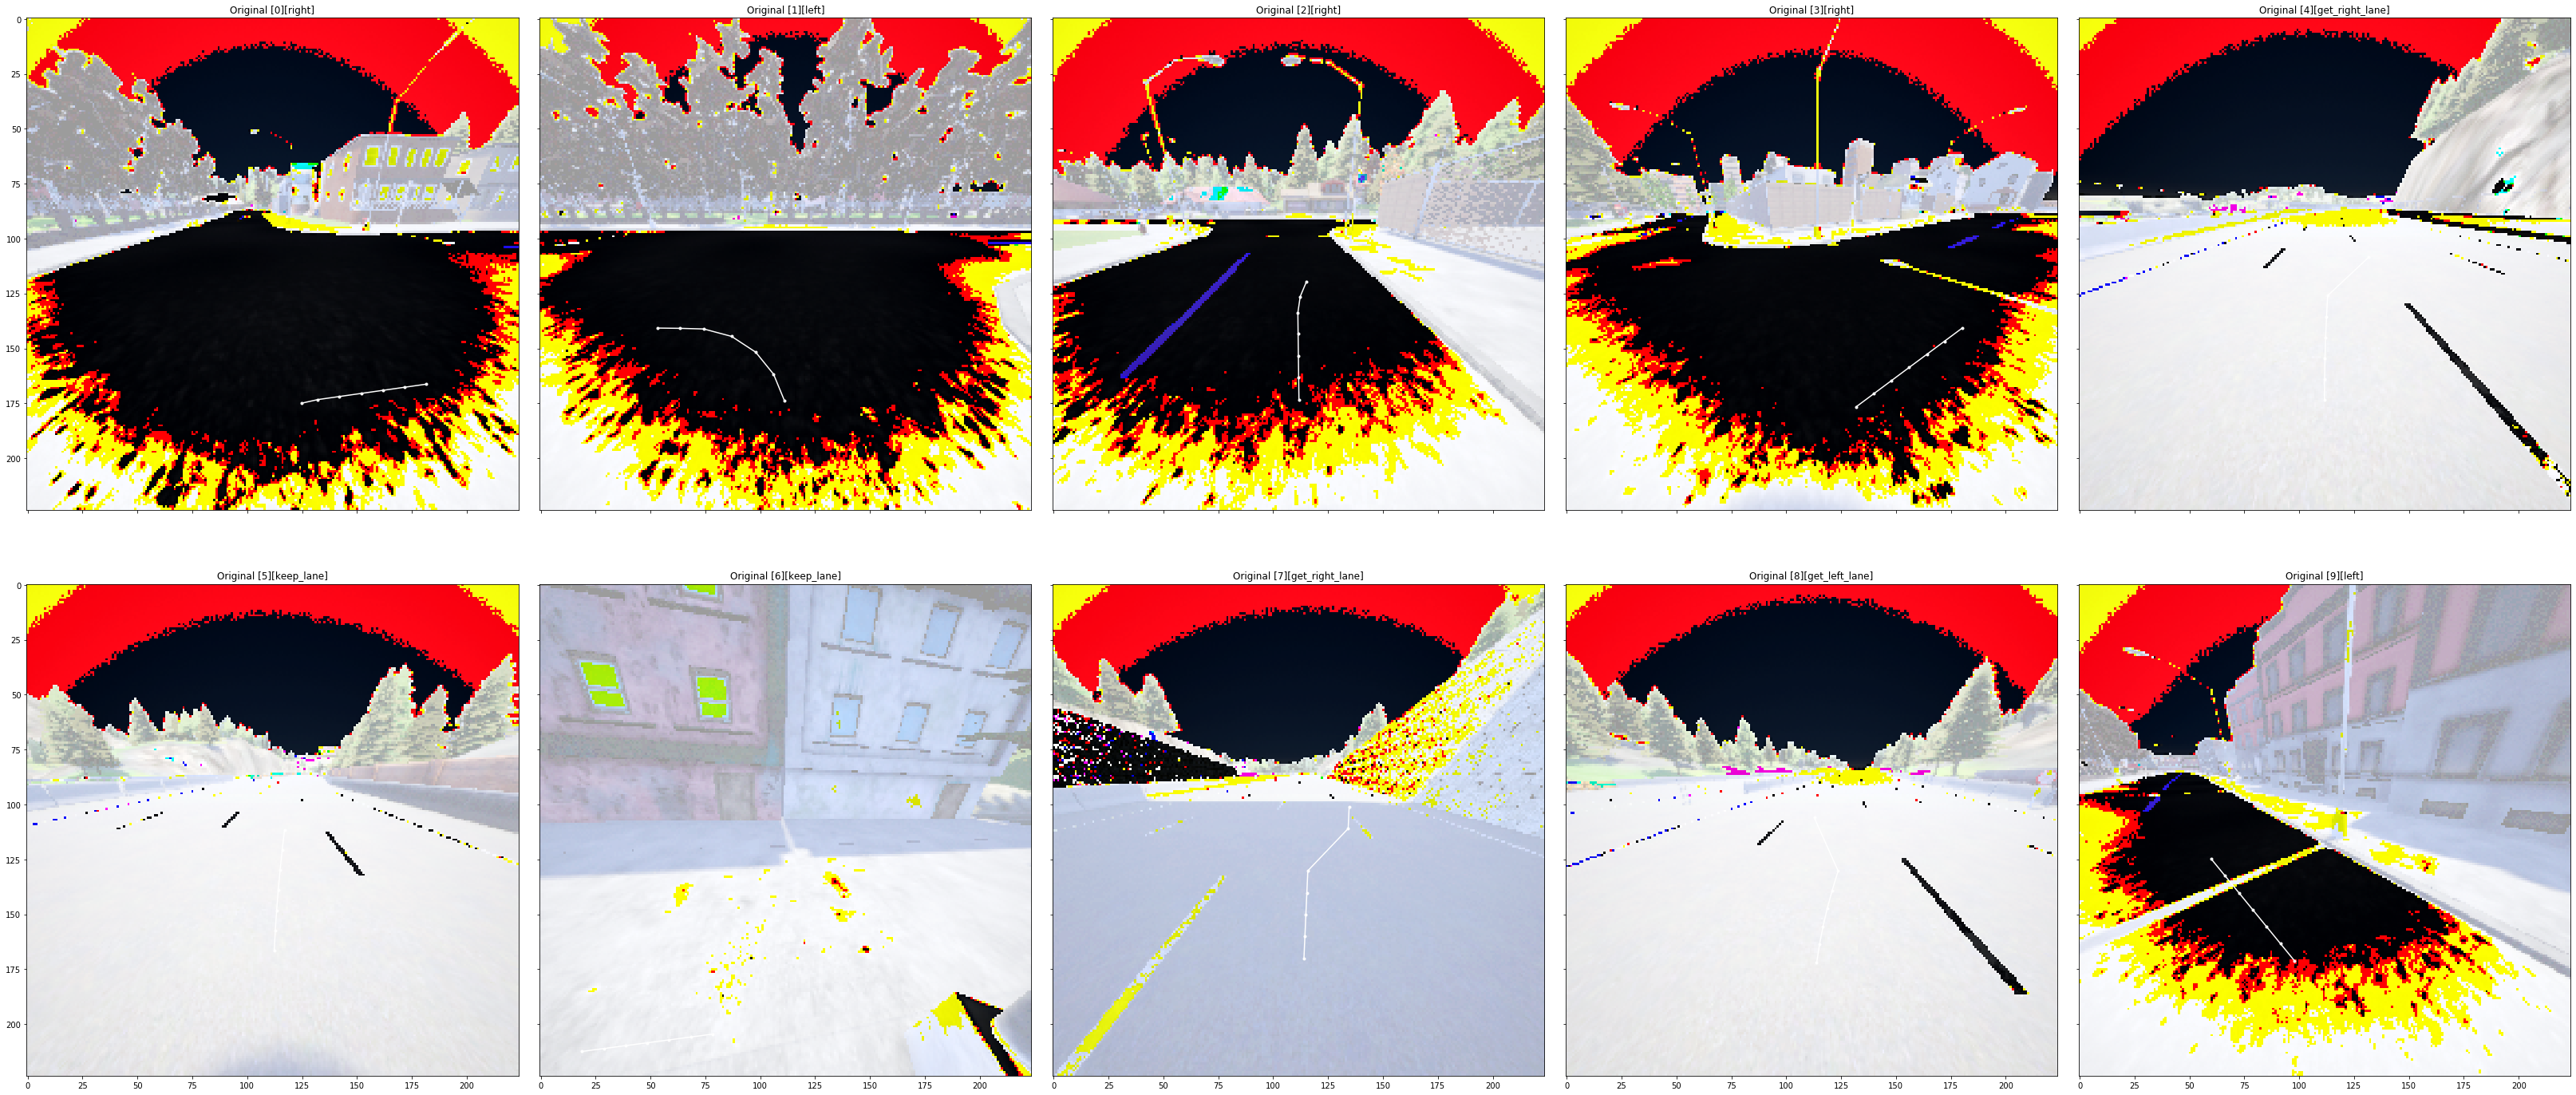

In [47]:
random_batch_idx = random.randint(0, len(ds) - 1)
visualize_batch(ds[random_batch_idx])

In [48]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.eager import context

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir, **kwargs):
        self.val_log_dir = os.path.join(log_dir, 'validation')
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

    def set_model(self, model):
        if context.executing_eagerly():
            self.val_writer = tf.contrib.summary.create_file_writer(self.val_log_dir)
        else:
            self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def _write_custom_summaries(self, step, logs=None):
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if 'val_' in k}
        if context.executing_eagerly():
            with self.val_writer.as_default(), tf.contrib.summary.always_record_summaries():
                for name, value in val_logs.items():
                    tf.contrib.summary.scalar(name, value.item(), step=step)
        else:
            for name, value in val_logs.items():
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.val_writer.add_summary(summary, step)
        self.val_writer.flush()

        logs = {k: v for k, v in logs.items() if not 'val_' in k}
        super(TrainValTensorBoard, self)._write_custom_summaries(step, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [49]:
LOSS_FUNCTION_NAME = 'mean_squared_error'

def freeze_layers(model):
    for layer in model.layers:
        layer.trainable=False



def define_corrected_model():
    model_name = 'miczi_v10'
    
    # Inputs
    input_img_seq = Input(shape=(224, 224, 3))
    input_command = Input(shape=(6,))
    
    # Image branch
    base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
    freeze_layers(base_model)
    _ = Flatten()(base_model.output)
    _ = Dense(1024)(_)
    _ = Dropout(0.5)(_)
    cnn_output = Dense(256, activation='relu')(_)
    
    _ = concatenate([cnn_output, input_command])
    _ = Dense(128, activation='relu')(_)
    _ = Dropout(0.4)(_)
    outputs = Dense(14, activation='linear')(_)
        
    # Combine inputs, outputs
    model = Model(inputs=[base_model.input, input_command], outputs=outputs)
    model.compile(loss=LOSS_FUNCTION_NAME, optimizer='adam', metrics=['accuracy', 'mse', 'mae'])
    
    print(model_name, model.summary())
#     plot_model(model, show_shapes=True, to_file=model_name +'_plot.png')
    return model, model_name

def define_lstm_model():
    model_name = 'miczi_v11'
    
    # Inputs
    input_img_seq = Input(shape=(224, 224, 3))
    input_command = Input(shape=(6,))
    
    # Image branch
    base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
    freeze_layers(base_model)
    _ = Flatten()(base_model.output)
    cnn_output = Dense(256, activation='relu')(_)
    
    _ = concatenate([cnn_output, input_command])
    _ = Dense(128, activation='relu')(_)
    _ = Dropout(0.2)(_)
    _ = Dense(64, activation='relu')(_)
    _ = LSTM(32, dropout=0.2, input_shape=(64, 1), return_sequences=True)(_)
    outputs = Dense(14, activation='linear')(_)
        
    # Combine inputs, outputs
    model = Model(inputs=[base_model.input, input_command], outputs=outputs)
    model.compile(loss=LOSS_FUNCTION_NAME, optimizer='adam', metrics=['accuracy', 'mse', 'mae'])
    
    print(model_name, model.summary())
#     plot_model(model, show_shapes=True, to_file=model_name +'_plot.png')
    return model, model_name

def define_model():
    model_name = 'miczi_v12'
    
    # Inputs
    input_img_seq = Input(shape=(224, 224, 3))
    input_command = Input(shape=(6,))
#     encoded = noise.GaussianNoise(0.2)(input_sh)
    
    # Image branch
    cnn_model = MobileNetV2(input_shape=(224,224,3), include_top=False, pooling='avg', weights='imagenet')
    freeze_layers(cnn_model)
    _ = Dense(512)(cnn_model.output)
    _ = Dropout(0.4)(_)
    cnn_output = Dense(128)(_)

    # Merge two branches: features extracted by CNN with command    
    _ = concatenate([cnn_output, input_command])
    _ = Dense(128, activation='relu')(_)
    _ = Dense(128, activation='relu')(_)
    _ = Dense(64, activation='relu')(_)
    outputs = Dense(14, activation='linear')(_)
        
    # Combine inputs, outputs
    model = Model(inputs=[cnn_model.input, input_command], outputs=outputs)
    model.compile(loss=LOSS_FUNCTION_NAME, optimizer='adam', metrics=['accuracy', 'mae'])
    
    print(model_name, model.summary())
#     plot_model(model, show_shapes=True, to_file=model_name +'_plot.png')
    return model, model_name

In [50]:
# Training setup
# from keras.utils.training_utils import multi_gpu_model

model, model_name = define_model()
# multigpu_model = multi_gpu_model(model)

W0805 19:54:53.598607 140513918494528 deprecation.py:506] From /home/bwroblew/miniconda3/envs/waypoint_prediction_env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [51]:
BATCH_SIZE = 512 # Adam w paperze oryginalnym ma 128
train_set_gen = ImageDatasetGenerator(TRAIN_DATASET_DIRS, batch_size=BATCH_SIZE)
test_set_gen = ImageDatasetGenerator(TEST_DATASET_DIRS, batch_size=BATCH_SIZE)

In [54]:
DESCRIPTION = 'normalized__train_ds1+2+3_test_ds1__bs_{}_bigger'.format(BATCH_SIZE)
checkpoint_path = f'training_{model_name}__{DESCRIPTION}/checkpoint.ckpt' # _{epoch:02d}_{val_acc:.2f}.ckpt'
checkpointing_callback = ModelCheckpoint(filepath=checkpoint_path,
                                         save_weights_only=True,
                                         monitor=LOSS_FUNCTION_NAME,
                                         verbose=1,
                                         save_freq='epoch')
plot_callback = PlotLossesCallback()
tensorboard_callback = TrainValTensorBoard(log_dir=f'./tensorboard_logs_{model_name}__{DESCRIPTION}',
                                   batch_size=BATCH_SIZE,
#                                    histogram_freq=1,
                                   write_graph=False,
                                   write_images=False)
# tensorboard_callback = TensorBoard(log_dir=f'./tensorboard_logs_{model_name}__{DESCRIPTION}',
#                                    batch_size=BATCH_SIZE,
#                                    histogram_freq=0,
#                                    write_graph=True,
#                                    write_images=True)
#tensorboard_colab = TensorBoardColab()
#tensorboard_colab_callback = TensorBoardColabCallback(tensorboard_colab)

# # TODO Check this out
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='auto', restore_best_weights=True)

callbacks = [checkpointing_callback, plot_callback, 
             tensorboard_callback, 
             reduce_lr_callback, early_stopping_callback
            ]

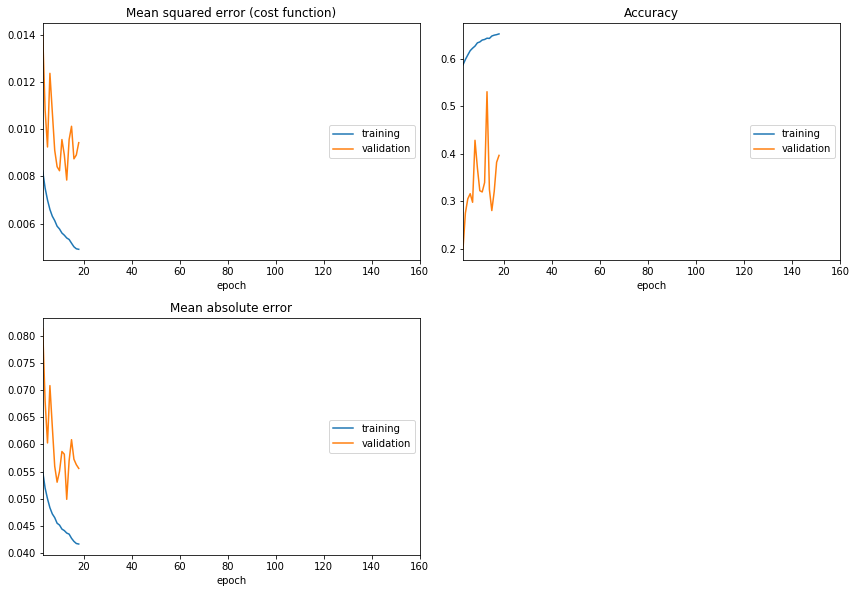

W0805 22:45:05.135934 140513918494528 callbacks.py:1833] Reduce LR on plateau conditioned on metric `mean_squared_error` which is not available. Available metrics are: loss,acc,mean_absolute_error,val_loss,val_acc,val_mean_absolute_error,lr


Mean squared error (cost function):
training   (min:    0.005, max:    0.027, cur:    0.005)
validation (min:    0.008, max:    0.022, cur:    0.009)

Accuracy:
training   (min:    0.405, max:    0.653, cur:    0.653)
validation (min:    0.199, max:    0.531, cur:    0.397)

Mean absolute error:
training   (min:    0.042, max:    0.102, cur:    0.042)
validation (min:    0.050, max:    0.109, cur:    0.056)
Restoring model weights from the end of the best epoch.
512/512 [==============================] - 587s 1s/step - loss: 0.0049 - acc: 0.6526 - mean_absolute_error: 0.0417 - val_loss: 0.0094 - val_acc: 0.3966 - val_mean_absolute_error: 0.0556
Epoch 00018: early stopping


In [53]:
# Train
try:
    model.load_weights(checkpoint_path)
except:
    print('No checkpoint to load!!!')
model.fit_generator(train_set_gen,
                    steps_per_epoch=len(train_set_gen),
                    validation_data=test_set_gen,
                    validation_steps=len(test_set_gen),
                    shuffle=True,
                    epochs=160,
                    callbacks=callbacks,
                    verbose=1,
                    workers=20,
                    use_multiprocessing=True,
                    max_queue_size=80,
                    initial_epoch=0
                   )
# !ls -l --block-size=M training_miczi_v3
# files.download(checkpoint_path)

# DGX, Full dataset "bingo" , BS=40, EP=20, no mini-batch shuffling

Hello Im here!!!
1/1 [==============================] - 0s 7ms/sample


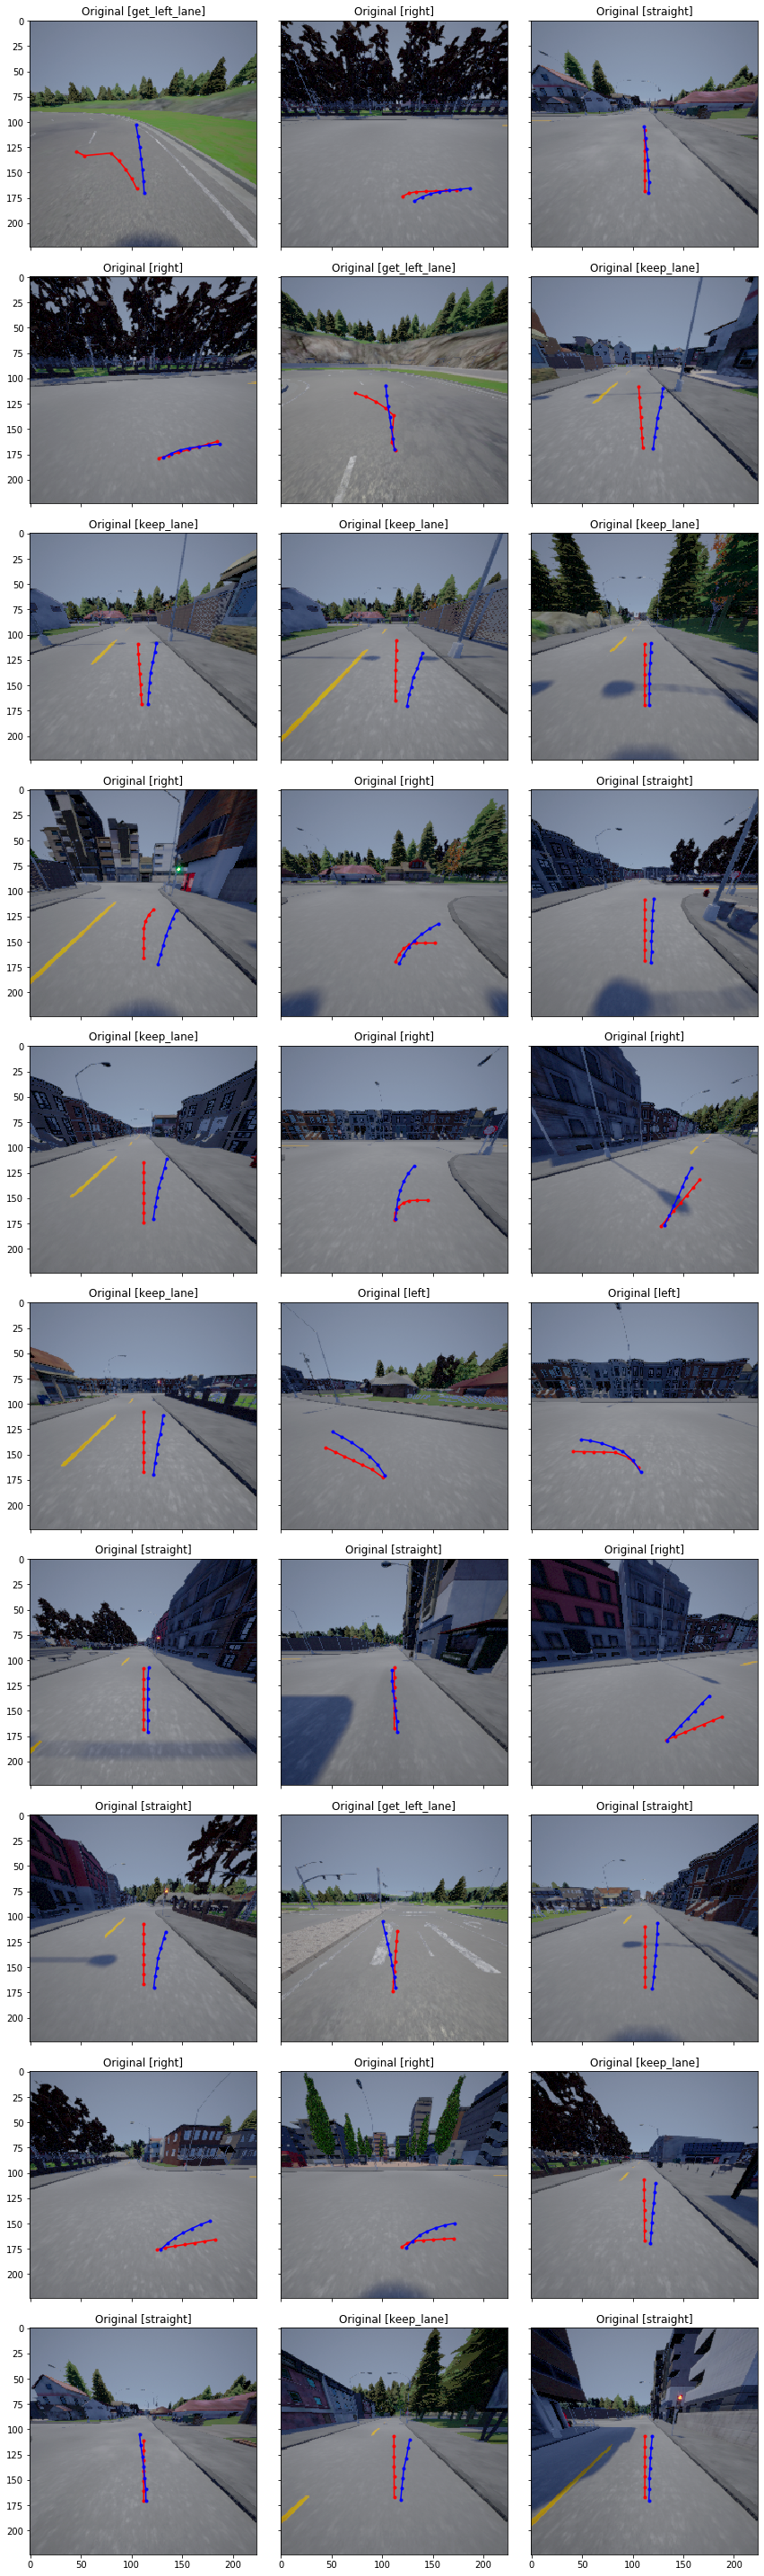

In [30]:
# Evaluate model
print('Hello Im here!!!')
TEST_DATASET_DIR = Path('/home/bwroblew/Datasets/waypoint_prediction_reworked/test')

img_paths = [path for path in TEST_DATASET_DIR.glob('*.png')]
model.load_weights(checkpoint_path)



def visualize_evaluation(img_paths: Path):
    nrows, ncols = 10, 3
    img_paths_sample = random.sample(img_paths, nrows * ncols)
    
    fig, axes = plt.subplots(nrows,ncols, figsize=(4*ncols, 4*nrows), sharex='all', sharey='all')
    fig.tight_layout()
    for row in range(nrows):
        for col in range(ncols):
            # Load image
            img_path = img_paths_sample[row * ncols + col]
            img = load_preprocessed_image(img_path)
            orig_img = load_image(img_path)
            input_img = np.expand_dims(img, axis=0)
            
            # Load target spline
            data = load_json(img_path.parent / f'{img_path.stem}.json')
            target_flatten_spline = get_spline(data)
            
            # Load GT command
            command_onehot = get_command_input(data)
            command = onehot_to_command(command_onehot)
            input_command = np.expand_dims(command_onehot, axis=0)
    
            # Predict
            predicted_spline = model.predict([input_img, input_command], verbose=1)
            
            
            ax = axes[row, col]
            # Display image with command
            ax.set_title(f'Original [{command}]')
#             (preprocessed_image * 255)
            ax.imshow(orig_img) #np.uint8(img * 255))

            # Overlay with spline
            xs, ys = plottable_spline(target_flatten_spline)
            ax.plot(xs, ys, '.-r')

            predicted_flatten_spline = np.squeeze(predicted_spline)    
            xs, ys = plottable_spline(predicted_flatten_spline)
            ax.plot(xs, ys, '.-b')
        fig.show()

visualize_evaluation(img_paths)